![](https://seeklogo.com/images/T/tripadvisor-logo-6939149F8F-seeklogo.com.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./data/kaggle_task.csv
./data/main_task.csv
./data/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = './data'
df_train = pd.read_csv(DATA_DIR + '/main_task.csv')
df_test = pd.read_csv(DATA_DIR + '/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* `City`: Город 
* `Cuisine Style`: Кухня
* `Ranking`: Ранг ресторана относительно других ресторанов в этом городе
* `Price Range`: Цены в ресторане в 3 категориях
* `Number of Reviews`: Количество отзывов
* `Reviews`: 2 последних отзыва и даты этих отзывов
* `URL_TA`: страница ресторана на 'www.tripadvisor.com' 
* `ID_TA`: ID ресторана в TripAdvisor
* `Rating`: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
37795,id_5990,Paris,NaN,5991.0,NaN,6.0,"[['The best'], ['10/19/2017']]",/Restaurant_Review-g187147-d12718828-Reviews-T...,d12718828,1,4.5
37432,id_2161,Madrid,"['Mediterranean', 'Spanish']",2163.0,$,43.0,[['A good place for eating cheap and traditio....,/Restaurant_Review-g187514-d6773388-Reviews-Re...,d6773388,1,4.5
11927,id_13357,Paris,"['Mexican', 'American', 'Bar']",13359.0,$$ - $$$,348.0,"[['Disappointing', 'Mediocre food and service'...",/Restaurant_Review-g187147-d1109813-Reviews-In...,d1109813,1,2.5
37016,id_5106,London,"['Bar', 'British', 'Pub', 'Vegetarian Friendly...",5115.0,$$ - $$$,145.0,"[['Ration roasts', 'A very friendly local'], [...",/Restaurant_Review-g186338-d1571641-Reviews-Th...,d1571641,1,3.5
40475,id_11582,Paris,['Chinese'],11584.0,$$ - $$$,12.0,"[['Good neighborhood restaurant'], ['12/22/201...",/Restaurant_Review-g187147-d858380-Reviews-Au_...,d858380,1,4.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [15]:
# Для примера я возьму столбец Number of Reviews
def preproc_number_of_reviews(df):
    # Вынесем информацию о наличии пропуска как отдельный признак
    df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
    # Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
    df['Number of Reviews'].fillna(0, inplace=True)
    return df

data = preproc_number_of_reviews(data)

In [16]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

### 2. Обработка признаков

#### Возьмем признак "Price Range".

In [17]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [18]:
def preproc_price_range(df):
    # Заменим категориальный признак числами
    df['Price Range'].replace(to_replace={ '$': 1, '$$ - $$$': 2, '$$$$': 3}, inplace=True)
    # Сохраним данные о записях, где не был указан уровень цен.
    df['Price_Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
    # Заполним пропуски, пока что воспользуемся просто медианой.
    df['Price Range'].fillna(df['Price Range'].median(), inplace=True)
    return df

data = preproc_price_range(data)

In [19]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Price_Range_isNAN
25176,id_2844,Paris,"['French', 'Vegetarian Friendly']",2845.0,1.0,295.0,"[['Sweet and savoury delights', 'Fun, friendly...",/Restaurant_Review-g187147-d789407-Reviews-Cre...,d789407,1,4.0,0,0
9288,id_9288,Vienna,['Chinese'],1446.0,2.0,18.0,"[['Wonderful - highly recommended', 'Tasty dis...",/Restaurant_Review-g190454-d5976547-Reviews-Re...,d5976547,0,0.0,0,0
12979,id_2756,Paris,"['Japanese', 'Sushi']",2757.0,2.0,31.0,"[['Sushi Lunch.', 'Why go anywhere else?'], ['...",/Restaurant_Review-g187147-d715090-Reviews-Fou...,d715090,1,4.5,0,0
9679,id_9679,Barcelona,NaN,5114.0,2.0,3.0,"[['Fabulous little place'], ['08/16/2015']]",/Restaurant_Review-g187497-d8536259-Reviews-I_...,d8536259,0,0.0,0,1
6814,id_6814,Lyon,['European'],1105.0,2.0,108.0,"[['Nice ambiance, great service', 'Lovely find...",/Restaurant_Review-g187265-d2560570-Reviews-Gr...,d2560570,0,0.0,0,0


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

#### Возьмем следующий признак "Cuisine Style".

Для начала добавим к записям признак с колличеством представленых типов кухонь. Если в данных отсутствует информация о типах кухонь, то считаем, что в этом ресторане предлагается только один тип кухни. Так же пометим записи, где не укзан тип кухни.

In [20]:
def string_to_list(s):
    return s[1:-1].replace("'", "").split(', ')

def count_styles(s):
    return len(string_to_list(s)) if s is not np.nan else 1

def get_cuisines_list(df):
    cuisines = set()
    for cuisine in df['Cuisine Style'].dropna().values:
        cuisines.update(string_to_list(cuisine))
    return cuisines

def update_cuisines_rating(cuisine_styles, cuisines_ratings):
        for style in cuisine_styles:
            cuisines_ratings[style] = cuisines_ratings[style] + 1

def calc_cuisines_ratings(df, cuisines):
    cuisines_ratings = {}
    for cuisine in cuisines:
        cuisines_ratings[cuisine] = 0
    
    for cuisine in df['Cuisine Style'].dropna().values:
        update_cuisines_rating(string_to_list(cuisine), cuisines_ratings)
    
    return cuisines_ratings

def preproc_cuisine_style(df):
    # добавим к записям признак с колличеством представленых типов кухонь
    df['Cuisine Style Count'] = df['Cuisine Style'].apply(count_styles)
    # пометим записи, где не укзан тип кухни.
    df['Cuisine_Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')

    # отдельными признаками добавим типы кухни, которые представлены хотя бы в 1% ресторанов.
    # соберем список всех кухонь представленых в датасете.
    cuisines_list = get_cuisines_list(df)

    # соберем данные о том, в скольки ресторанах представлена каждая кухня.
    cuisines_rating = calc_cuisines_ratings(df, cuisines_list)

    # выделим две группы кухонь те которые представлены хотя бы в 1% ресторанов и остальные
    top_cuisines = []
    low_cuisines = []
    for cuisine in cuisines_rating:
        if cuisines_rating[cuisine] > len(data) * .01:
            top_cuisines.append(cuisine)
        else:
            low_cuisines.append(cuisine)

    # создадим отдельные признаки для кухонь представленых хотя бы в 1%
    def top_cuisine_present(x):
        if pd.isna(x): 
            return 0
        return 1 if cuisine in x else 0

    for cuisine in top_cuisines:
        dummy = df['Cuisine Style'].apply(top_cuisine_present)
        df['Cuisine_' + cuisine] = dummy

    # для остальных добавим признак Cuisine_Other
    def is_low_cuisine_present(x):
        if pd.isna(x): 
            return 0
        for cuisine in low_cuisines:
            if cuisine in x:
                return 1
        return 0

    df['Cuisine_Other'] = df['Cuisine Style'].apply(is_low_cuisine_present)
    
    return df

data = preproc_cuisine_style(data)

In [21]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Cuisine_Cafe,Cuisine_Grill,Cuisine_Mexican,Cuisine_Fast Food,Cuisine_Spanish,Cuisine_German,Cuisine_Greek,Cuisine_Chinese,Cuisine_Gluten Free Options,Cuisine_Other
48698,id_2504,Hamburg,NaN,2509.0,2.0,0.0,"[[], []]",/Restaurant_Review-g187331-d11882314-Reviews-B...,d11882314,1,...,0,0,0,0,0,0,0,0,0,0
23176,id_2891,Prague,"['European', 'Czech']",2897.0,2.0,5.0,"[['Good For Pre-Match Drink'], ['11/29/2015']]",/Restaurant_Review-g274707-d4767527-Reviews-Re...,d4767527,1,...,0,0,0,0,0,0,0,0,0,0
15090,id_9370,Paris,NaN,9372.0,2.0,18.0,"[['Quaint Pub', 'Choice of drinks'], ['07/29/2...",/Restaurant_Review-g187147-d10310146-Reviews-C...,d10310146,1,...,0,0,0,0,0,0,0,0,0,0
43764,id_1198,Copenhagen,"['Steakhouse', 'European', 'Danish']",1200.0,2.0,93.0,"[['Good food, but the restaurant close very e....",/Restaurant_Review-g189541-d8712153-Reviews-LO...,d8712153,1,...,0,0,0,0,0,0,0,0,0,1
24857,id_4400,Paris,['French'],4401.0,2.0,70.0,"[['Cozy atmosphere great food', 'Cheap for a v...",/Restaurant_Review-g187147-d3601244-Reviews-Mo...,d3601244,1,...,0,0,0,0,0,0,0,0,0,0


#### Возьмем следующий признак "Reviews".

Добавим признаки с датами последнего и предпоследнего отзывов, а также колличество дней между ними.

In [22]:
def get_dates_list(x):
    dates = x.split('], [')[1]
    dates = dates[:-2]
    dates = dates.replace("'", "")
    return dates.split(', ')

def get_penultimate_review(x):
    dates = get_dates_list(x)
    return pd.to_datetime(dates[-1]) if len(dates) >= 1 else np.NaN

def get_last_review(x):
    dates = get_dates_list(x)
    return pd.to_datetime(dates[0]) if len(dates) >= 1 else np.NaN

def preproc_reviews(df):
    # заполним пропуски пустыми значениями
    df['Reviews'].fillna('[[], []]', inplace=True)

    # отметим записи коментарии в которых отсутствуют
    df['Reviews_NA'] = (df['Reviews'] == '[[], []]').astype(int)

    # создадим признаки с датами двух последних коментариев
    df['Penultimate_Review'] = df['Reviews'].apply(lambda x: get_penultimate_review(x))
    df['Last_Review'] = df['Reviews'].apply(lambda x: get_last_review(x))

    # создадим признак количеством дней прошедшими между двумя последними коментариями
    df = df.assign(Review_Time_Delta = lambda x: (x['Last_Review'] - x['Penultimate_Review']).dt.days)

    # звполним пустые записи
    df['Review_Time_Delta'] = df['Review_Time_Delta'].fillna(0)
    return df

data = preproc_reviews(data)

In [23]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Cuisine_Spanish,Cuisine_German,Cuisine_Greek,Cuisine_Chinese,Cuisine_Gluten Free Options,Cuisine_Other,Reviews_NA,Penultimate_Review,Last_Review,Review_Time_Delta
21874,id_528,Barcelona,"['Mediterranean', 'European', 'Spanish', 'Vege...",529.0,2.0,264.0,"[['Catalan Lunch Menu', 'Friendly, nice waiter...",/Restaurant_Review-g187497-d3399797-Reviews-Xo...,d3399797,1,...,1,0,0,0,1,0,0,2017-11-18,2018-01-09,52.0
28233,id_10004,London,"['Bar', 'British', 'Pub']",10013.0,1.0,29.0,"[['Always a pleasure', 'Great place for a quic...",/Restaurant_Review-g186338-d7229140-Reviews-Th...,d7229140,1,...,0,0,0,0,0,0,0,2017-05-09,2017-08-20,103.0
1773,id_1773,Vienna,"['German', 'European', 'Central European', 'Br...",111.0,2.0,611.0,"[['Nice lunch', 'Austrian food'], ['12/13/2017...",/Restaurant_Review-g190454-d1027788-Reviews-Br...,d1027788,0,...,0,1,0,0,1,1,0,2017-10-20,2017-12-13,54.0
11575,id_311,Rome,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",312.0,1.0,1217.0,"[['Ultimate pizza dining experience', 'Great p...",/Restaurant_Review-g187791-d1901134-Reviews-Li...,d1901134,1,...,0,0,0,0,0,0,0,2018-01-06,2018-01-08,2.0
31364,id_2120,London,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",2124.0,2.0,290.0,"[['A hidden gem', ""Good food in a crazy expens...",/Restaurant_Review-g186338-d967477-Reviews-Del...,d967477,1,...,0,0,0,0,1,0,0,2017-10-23,2017-12-02,40.0


Посмотрим какие признаки у нас могут быть категориальными.

In [24]:
data.nunique(dropna=False)

Restaurant_id         13094
City                     31
Cuisine Style         10732
Ranking               12975
Price Range               3
                      ...  
Cuisine_Other             2
Reviews_NA                2
Penultimate_Review     2279
Last_Review            1977
Review_Time_Delta      1650
Length: 63, dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [25]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na

def preproc_cities(df):

    # Прежде, чем заменять признак 'City' dummy-переменными, сохраним на будущее некоторую информацию.
    # Соберем среднее значение критерия Ranking по городам
    stats_by_city = df.groupby(['City']).median()   
    
    # Для каждой строчки добавим признак с отклонением от среднего значения соответствующего города
    df['Ranking_Delta'] = df.apply(lambda x: x['Ranking'] - stats_by_city['Ranking'][x['City']], axis=1)
    df['Cuisine_Style_Count_Delta'] = df.apply(lambda x: x['Cuisine Style Count'] - stats_by_city['Cuisine Style Count'][x['City']], axis=1)
    df['Price_Range_Delta'] = df.apply(lambda x: x['Price Range'] - stats_by_city['Price Range'][x['City']], axis=1)
    df['Reviews_Number_City_Median_Delta'] = df.apply(lambda x: x['Number of Reviews'] - stats_by_city['Number of Reviews'][x['City']], axis=1)

    df = pd.get_dummies(df, columns=['City'], dummy_na=True)
    return df

data = preproc_cities(data)

In [26]:
data.sample()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
20622,id_154,"['Asian', 'Thai', 'Vegetarian Friendly', 'Vega...",155.0,1.0,756.0,"[['Authentic Thai Food at Reasonable Price', '...",/Restaurant_Review-g186525-d5279781-Reviews-Ti...,d5279781,1,4.0,...,0,0,0,0,0,0,0,0,0,0


Попробуем по тексту двух последних коментариев понять были ли они положительными либо отрицательными.

In [27]:
data['Reviews'].sample(5)

1930                                              [[], []]
44400    [['Great food for half the price compare to t....
27487    [['Beautiful surrounding and great craft beer....
40022    [['Fantastic food and environment', 'AMAZING!'...
38235    [['Close to the Station', 'Good food at reason...
Name: Reviews, dtype: object

In [28]:
chars_to_replace = "',.!?&-+/\""

def get_reviews_words(x):
    reviews = x.split('], [')[0]
    reviews = reviews[2:]
    reviews = reviews.split("', '")
    if len(reviews) == 1:
        return []

    words = set()
    for review in reviews:
        for ch in chars_to_replace:
            review = review.replace(ch, '')
        review = review.lower()
    return words

def count_review_words(x):
    words = get_reviews_words(x)

# для начала соберем список слов которые есть в коментариях.
# data['Reviews'].sample(10).apply(count_review_words)
# в процессе выяснилось, что подавляющее большинство коментариев положительные, пока отложим это

### Это "жжж" неспроста

В датасете у нас есть ссылка страничку ресторана в системе TripAdrisor. Рассмотрим несколько страниц и попробуем выделить потенциально полезную нам информацию.

Опишем необходимые для парсинга функции

In [29]:
import requests

from lxml import html
from bs4 import BeautifulSoup
from multiprocessing import Pool
from datetime import datetime

TRIP_ADVISOR_URL_TEMPLATE = 'https://www.tripadvisor.com{}'

def parse_ratings_and_reviews(node, result):
    rating_block = node.find('div').findAll('div', recursive=False)[2]
    rating_block = rating_block.findAll('div', recursive=False)
    if len(rating_block) < 2:
        return

    ratings = rating_block[1].findAll('div')
    for rating in ratings:
        spans = rating.findAll('span', recursive=False)
        title = spans[1].text.lower()
        value = spans[2].find('span').attrs['class'][1].split('_')[1]
        result[title] = int(value)

def parse_location_and_contact(node):
    location_block = node.find('div').find('div')
    location_block = location_block.findAll('div', recursive=False)[1]
    distance_el = location_block.find('b')
    if distance_el is None:
        return np.NaN
    return float(distance_el.text.split()[0])

def parse_details_block(node, result):
    if node is None:
        return

    result['is_verified'] = 1 if node.find('span', {'class': 'ui_icon verified-checkmark'}) is not None else 0
    result['has_phone_number'] = 1 if node.find('a', string='+ Add phone number') is None else 0
    result['has_hours'] = 1 if node.find('a', string='+ Add hours') is None else 0
    result['has_website'] = 1 if node.find('a', string='+ Add website') is None else 0
    result['has_menu'] = 1 if node.find('a', string='Menu') is not None else 0
        

def collect_page_data(html, result):
    soup = BeautifulSoup(html)
    overview_tabs = soup.find('div', {'data-tab': 'TABS_OVERVIEW'})
    if overview_tabs is None:
        return

    overview_columns = overview_tabs.findAll('div', {'class':'ui_column'})
    parse_ratings_and_reviews(overview_columns[0], result)
    parse_details_block(overview_columns[1], result)

    result['distance'] = parse_location_and_contact(overview_columns[2])
    result['has_tcAward'] = 1 if soup.find('img', {'class': 'tcAward'}) is not None else 0

def current_time():
    return datetime.now().strftime("%H:%M:%S")

def get_id_from_url(url):
    return url.split('-')[2]

def parse_site_page(url):
    result = {}
    result['id_ta'] = get_id_from_url(url)
    ta_url = TRIP_ADVISOR_URL_TEMPLATE.format(url)
    print(url)
    r = requests.get(ta_url, stream=True)
    print('Done')
    collect_page_data(r.text, result)
    return result

def process_ta_urls(x):
    return x.apply(parse_site_page)

def parallelize_processing(df, func, n_cores=8):
    pool = Pool(n_cores)
    df_split = np.array_split(df, n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


In [30]:
print("Started at:", current_time())

start = 0
step = 200
stop = len(data)
n_cores = 4

for i in range(start, stop, step):
    print('[{}] Getting records {}:{}'.format(current_time(), i, i + step))
    pages_data = parallelize_processing(data['URL_TA'][i:i+step], process_ta_urls, n_cores=n_cores)
    site_df = pd.DataFrame(pages_data.values.tolist())
    site_df.to_csv('ta_data/data_{}-{}.csv'.format(i, i+step))    

print("Finished at:", current_time())

Started at: 00:55:08
[00:55:08] Getting records 0:200
/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html
/Restaurant_Review-g190454-d7813343-Reviews-Asia_Restaurant_Orangery-Vienna.html
/Restaurant_Review-g274887-d10788740-Reviews-Pizza_Raketa-Budapest_Central_Hungary.html
/Restaurant_Review-g274707-d12212609-Reviews-Hospudka_Knoflik-Prague_Bohemia.html
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/dkataiev/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/dkataiev/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/dkataiev/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/

KeyboardInterrupt: 

In [31]:
data['URL_TA'].to_csv('ta_urls.csv', header=False)

Удалим все признаки, не являющиесь числовыми.

In [117]:
object_cols = list(data.select_dtypes(include=['object', 'datetime64[ns]', 'timedelta64[ns]']).columns)
data = data.drop(labels=object_cols, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 91 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ranking                           50000 non-null  float64
 1   Price Range                       50000 non-null  float64
 2   Number of Reviews                 50000 non-null  float64
 3   sample                            50000 non-null  int64  
 4   Rating                            50000 non-null  float64
 5   Number_of_Reviews_isNAN           50000 non-null  uint8  
 6   Price_Range_isNAN                 50000 non-null  uint8  
 7   Cuisine Style Count               50000 non-null  int64  
 8   Cuisine_Style_isNAN               50000 non-null  uint8  
 9   Cuisine_French                    50000 non-null  int64  
 10  Cuisine_Turkish                   50000 non-null  int64  
 11  Cuisine_Portuguese                50000 non-null  int64  
 12  Cuis


![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 91 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ranking                           50000 non-null  float64
 1   Price Range                       50000 non-null  float64
 2   Number of Reviews                 50000 non-null  float64
 3   sample                            50000 non-null  int64  
 4   Rating                            50000 non-null  float64
 5   Number_of_Reviews_isNAN           50000 non-null  uint8  
 6   Price_Range_isNAN                 50000 non-null  uint8  
 7   Cuisine Style Count               50000 non-null  int64  
 8   Cuisine_Style_isNAN               50000 non-null  uint8  
 9   Cuisine_French                    50000 non-null  int64  
 10  Cuisine_Turkish                   50000 non-null  int64  
 11  Cuisine_Portuguese                50000 non-null  int64  
 12  Cuis

Взглянем на оставшиесь признакми в поисках выбросов.



### Посмотрим распределение признака

-0.016442353799205462

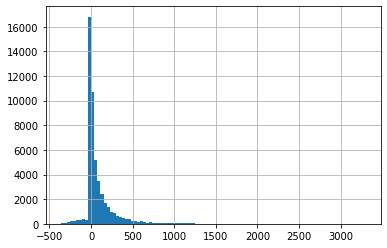

In [119]:
#### Review_Time_Delta
data['Review_Time_Delta'].hist(bins=100)

data['Review_Time_Delta'].corr(data['Rating'])

#### Review_Time_Delta

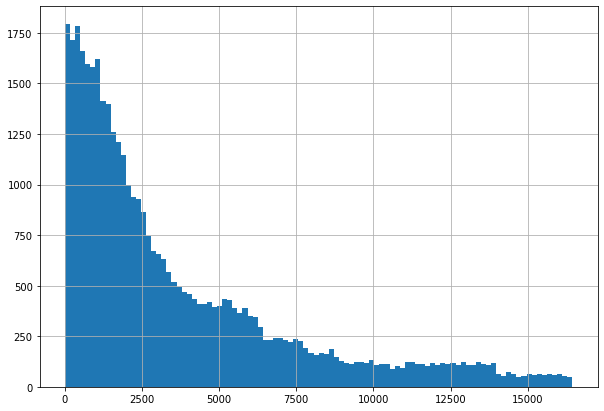

In [120]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

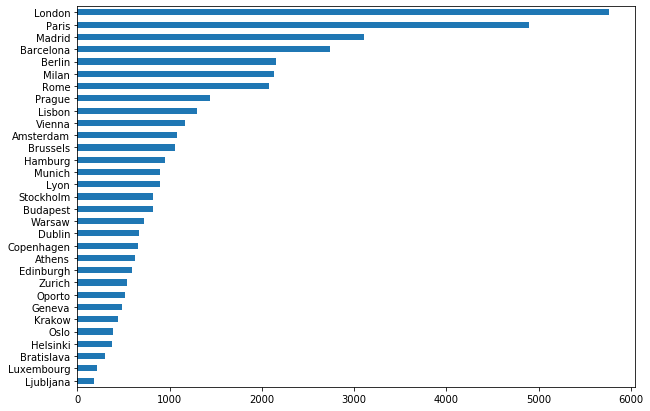

In [121]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

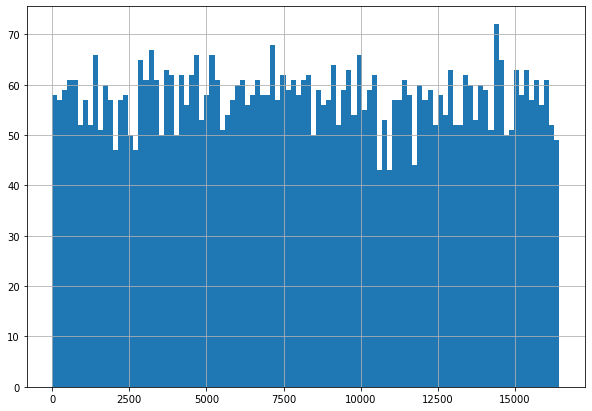

In [122]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

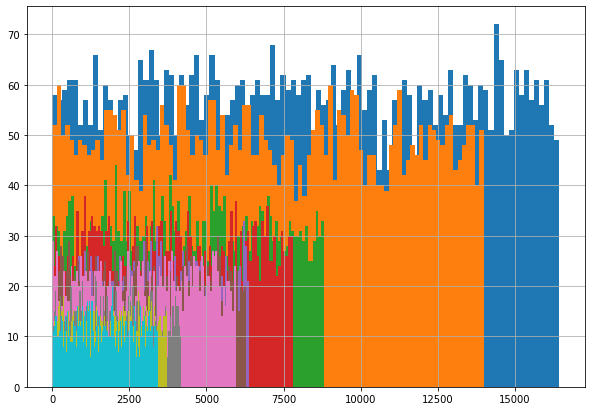

In [123]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

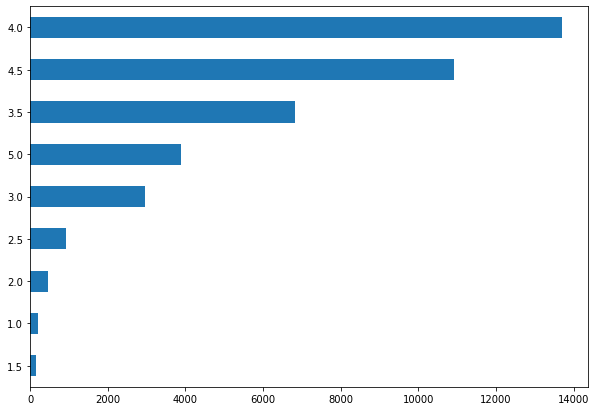

In [124]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

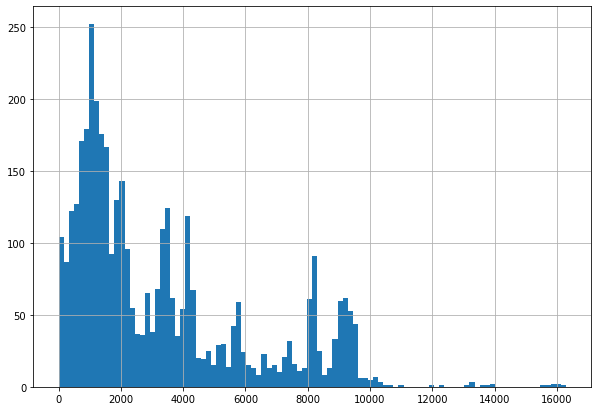

In [125]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

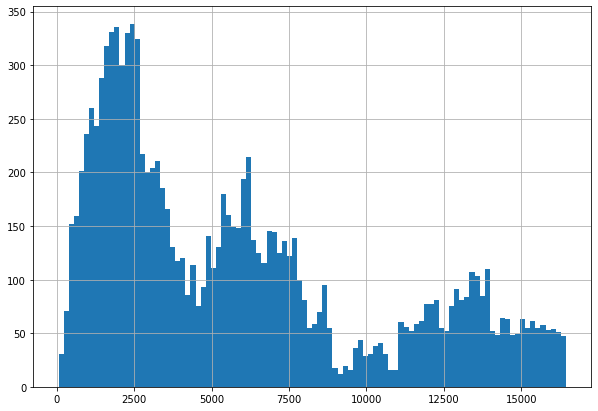

In [126]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

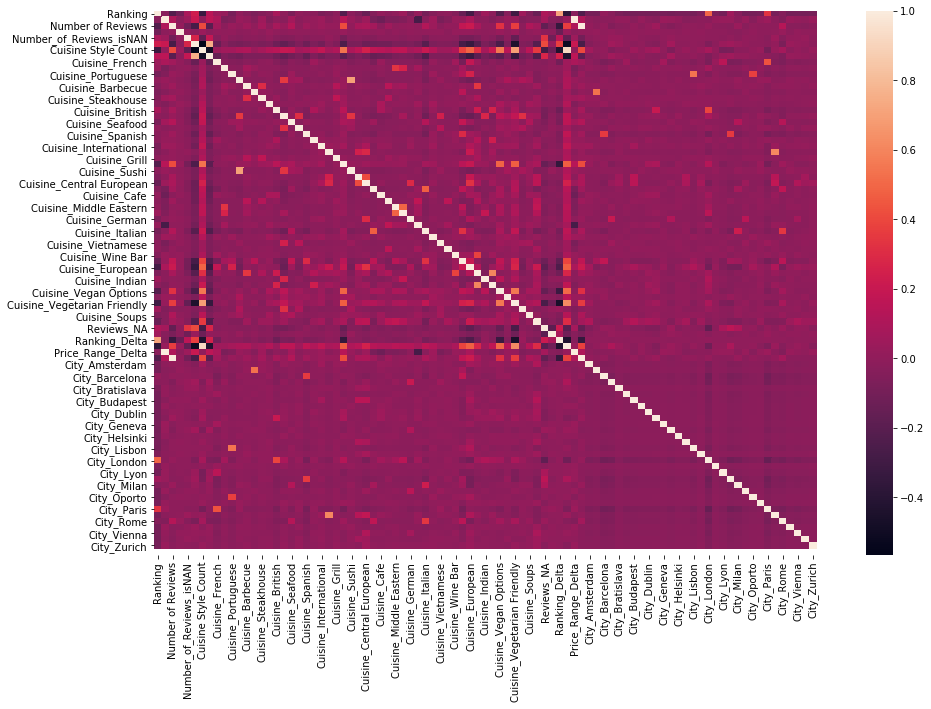

In [127]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [128]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [129]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд... 
    df_output = preproc_number_of_reviews(df_output)
    # тут ваш код по обработке NAN    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    # тут ваш код не Encoding фитчей
    
    df_output = preproc_price_range(df_output)

    df_output = preproc_cuisine_style(df_output)

    df_output = preproc_reviews(df_output)

    df_output = preproc_cities(df_output)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    # object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    # df_output.drop(object_columns, axis = 1, inplace=True)

    object_cols = list(df_output.select_dtypes(include=['object', 'datetime64[ns]', 'timedelta64[ns]']).columns)
    df_output = df_output.drop(labels=object_cols, axis=1)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [130]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine Style Count,Cuisine_Style_isNAN,Cuisine_French,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
18237,1480.0,3.0,120.0,1,4.5,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
43263,11622.0,2.0,28.0,1,3.0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
32517,5074.0,2.0,0.0,1,4.0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
40493,5303.0,2.0,193.0,1,3.5,0,0,4,0,0,...,0,0,0,0,1,0,0,0,0,0
45073,316.0,2.0,103.0,1,3.5,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
15816,10372.0,2.0,3.0,1,4.5,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
43040,7686.0,2.0,3.0,1,4.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
47018,2719.0,2.0,9.0,1,4.0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
20347,844.0,2.0,100.0,1,4.5,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4427,1368.0,1.0,23.0,0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 91 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ranking                           50000 non-null  float64
 1   Price Range                       50000 non-null  float64
 2   Number of Reviews                 50000 non-null  float64
 3   sample                            50000 non-null  int64  
 4   Rating                            50000 non-null  float64
 5   Number_of_Reviews_isNAN           50000 non-null  uint8  
 6   Price_Range_isNAN                 50000 non-null  uint8  
 7   Cuisine Style Count               50000 non-null  int64  
 8   Cuisine_Style_isNAN               50000 non-null  uint8  
 9   Cuisine_French                    50000 non-null  int64  
 10  Cuisine_Turkish                   50000 non-null  int64  
 11  Cuisine_Portuguese                50000 non-null  int64  
 12  Cuis

In [132]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

columns_for_scaling = ['Number of Reviews', 'Ranking', 'Review_Time_Delta', 'Ranking_Delta', 'Reviews_Number_City_Median_Delta', 'Cuisine_Style_Count_Delta', 'Price_Range_Delta', 'Reviews_Number_City_Median_Delta']

scaled_df = df_preproc[columns_for_scaling]
scaled_df.info()

scaler = StandardScaler()
scaled = scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(scaled)
scaled_df.columns = columns_for_scaling

for col in columns_for_scaling:
    df_preproc[col] = scaled_df[col]

df_preproc.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Number of Reviews                 50000 non-null  float64
 1   Ranking                           50000 non-null  float64
 2   Review_Time_Delta                 50000 non-null  float64
 3   Ranking_Delta                     50000 non-null  float64
 4   Reviews_Number_City_Median_Delta  50000 non-null  float64
 5   Cuisine_Style_Count_Delta         50000 non-null  int64  
 6   Price_Range_Delta                 50000 non-null  float64
 7   Reviews_Number_City_Median_Delta  50000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.1 MB


,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine Style Count,Cuisine_Style_isNAN,Cuisine_French,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
4449,-0.845238,2.0,0.319722,0,0.0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
41589,-0.293625,2.0,-0.382657,1,3.5,0,1,2,0,0,...,0,0,0,1,0,0,0,0,0,0
45768,1.102300,2.0,0.494443,1,3.0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
10574,-0.631998,1.0,-0.012248,1,3.5,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
25873,-0.638484,2.0,0.683142,1,4.0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
29031,-0.921994,2.0,2.210205,1,4.0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
44321,-0.608755,1.0,-0.393140,1,4.5,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31902,-0.946047,2.0,1.696525,1,4.5,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
15731,-0.804968,2.0,-0.228902,1,4.0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
5336,-0.660106,2.0,0.382622,0,0.0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
df_preproc['Rating']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
49995    4.5
49996    3.5
49997    4.5
49998    4.0
49999    3.0
Name: Rating, Length: 50000, dtype: float64

In [134]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [135]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [136]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 90), (40000, 90), (40000, 89), (32000, 89), (8000, 89))

# Model 
Сам ML

In [137]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [138]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [139]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [140]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20483437499999999


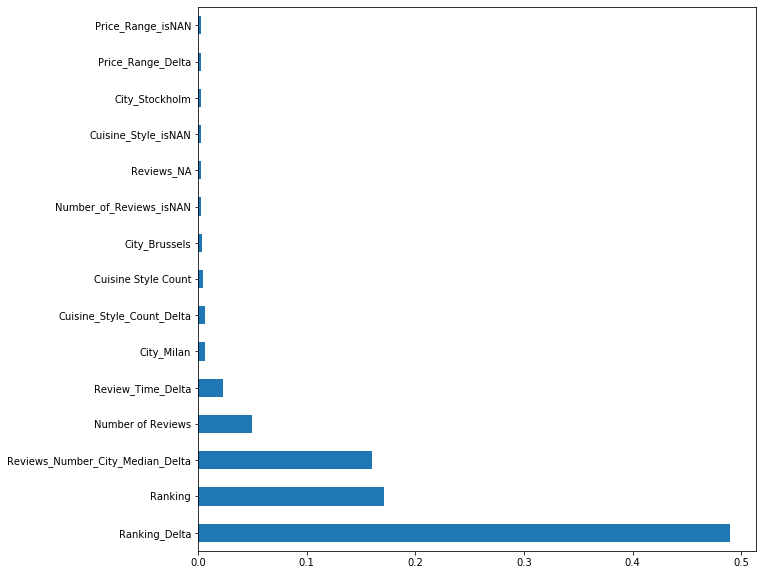

In [141]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [622]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,Ranking_Delta,Reviews_Number_Delta,City_Amsterdam,City_Athens,City_Barcelona,...,Cuisine_American,Cuisine_Grill,Cuisine_Thai,Cuisine_Mexican,Cuisine_Spanish,Cuisine_Cafe,Cuisine_Portuguese,Cuisine_Other,Reviews_NA,Review_Time_Delta
6116,0.173666,2.0,-0.354702,0.0,0,0.403067,-0.147357,0,0,0,...,0,0,0,0,0,0,0,1,0,2.887288
5446,-0.839833,1.0,-0.379163,0.0,0,-0.123887,-0.279502,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.302576
3210,-0.734699,1.0,0.711098,0.0,0,-1.124369,0.680302,0,0,1,...,1,0,0,0,0,0,0,0,0,0.309179
3930,-0.930102,2.0,0.934741,0.0,0,-0.630265,0.935440,0,0,0,...,0,0,0,0,0,0,1,0,0,-0.419101
9409,-0.385785,2.0,-0.267341,0.0,0,-1.802087,-0.247734,0,0,0,...,0,0,0,0,0,0,0,0,0,1.153983
9519,-0.634971,1.0,-0.214925,0.0,0,-0.295897,-0.220523,0,0,0,...,0,0,0,0,0,0,0,0,0,0.129536
2163,-0.390110,2.0,-0.169497,0.0,0,-0.635666,-0.214506,0,0,1,...,0,0,0,0,1,0,0,0,0,-0.190907
4472,-0.379840,2.0,-0.351207,0.0,0,-0.816235,-0.272132,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.122934
9842,-0.665511,2.0,-0.382657,0.0,0,0.172470,-0.425657,0,0,0,...,0,0,0,0,0,0,1,0,0,-0.438522
3629,-0.662538,1.0,-0.176486,0.0,0,-0.250802,-0.193723,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.229748


In [624]:
test_data = test_data.drop(['Rating'], axis=1)

KeyError: "['Rating'] not found in axis"

In [625]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [626]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [627]:
predict_submission

array([3.025, 4.355, 4.38 , ..., 3.01 , 4.445, 4.15 ])

In [628]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.025
1,id_1,4.355
2,id_2,4.380
3,id_3,4.405
4,id_4,4.435
5,id_5,4.420
6,id_6,2.900
7,id_7,2.770
8,id_8,4.540
9,id_9,4.730


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
